# Training: RGB Image

In [1]:
import torch
import warnings
import numpy as np 
import io
from datasets import load_dataset
from IPython.display import display, Image, update_display, HTML
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor
from fastprogress.fastprogress import master_bar, progress_bar
from walloc import walloc
from walloc.walloc import Round, ToUniform, ToNormal

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/89 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/85 [00:00<?, ?it/s]

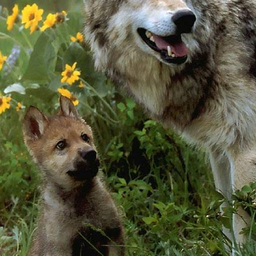

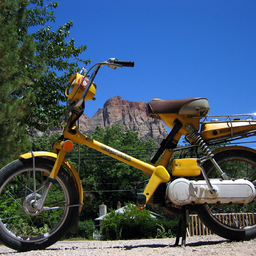

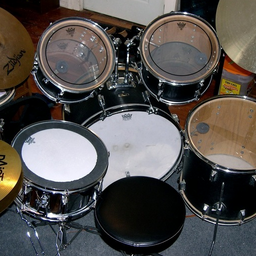

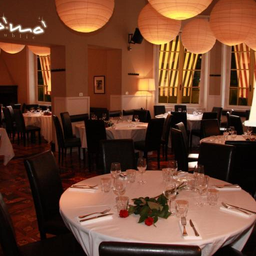

In [2]:
device = "cuda:0"
train_dataset = load_dataset("danjacobellis/LSDIR_540", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=4,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [3]:
class Config: pass
config = Config()
config.batch_size = 64
config.num_workers = 12
config.grad_accum_steps = 1
config.plot_update = 128
config.patience = 64
config.min_lr = 1e-7
config.max_lr = 3e-5
config.warmup_steps = 50000
config.weight_decay = 0.
config.epochs = 250
config.ϕ = 0.

config.channels=3
config.J = 4
config.latent_dim = 12
config.latent_bits = 8
config.num_stages = 4

In [5]:
import einops
from pytorch_wavelets import DWTForward, DWTInverse
class ResidualCodec2D(torch.nn.Module):
    def __init__(self, channels, J, latent_dim, latent_bits, num_stages):
        super(ResidualCodec2D, self).__init__()
        self.channels = channels
        self.J = J
        self.latent_dim = latent_dim
        self.latent_bits = latent_bits
        self.num_stages = num_stages
        self.latent_max = 2 ** (latent_bits - 1) - 1 + 0.5 - 1e-3
        self.wt = DWTForward(J=1, mode="periodization", wave="bior4.4")
        self.iwt = DWTInverse(mode="periodization", wave="bior4.4")
        self.clamp = torch.nn.Hardtanh(min_val=-0.5, max_val=0.5)

        # Entropy bottleneck
        self.to_uniform = ToUniform(
            scale=(2 ** (latent_bits - 1) - 1) / 1.85, latent_max=self.latent_max
        )
        self.round = Round()
        self.to_normal = ToNormal(
            scale=(2 ** (latent_bits - 1) - 1) / 1.85, latent_max=self.latent_max
        )

        # Single convolution layers for encoding and decoding
        self.encoders = torch.nn.ModuleList([
            torch.nn.Conv2d(
                in_channels=self.channels * (4 ** J),
                out_channels=self.latent_dim,
                kernel_size=1,
                stride=1,
                padding=0,
            ) for _ in range(num_stages)
        ])
        self.decoders = torch.nn.ModuleList([
            torch.nn.Conv2d(
                in_channels=self.latent_dim,
                out_channels=self.channels * (4 ** J),
                kernel_size=1,
                stride=1,
                padding=0,
            ) for _ in range(num_stages)
        ])

    def analysis_one_level(self, x):
        L, H = self.wt(x)
        X = torch.cat([L.unsqueeze(2), H[0]], dim=2)
        X = einops.rearrange(X, "b c f h w -> b (c f) h w")
        return X

    def wavelet_analysis(self, x, J=3):
        for _ in range(J):
            x = self.analysis_one_level(x)
        return x

    def synthesis_one_level(self, X):
        X = einops.rearrange(X, "b (c f) h w -> b c f h w", f=4)
        L, H = torch.split(X, [1, 3], dim=2)
        L = L.squeeze(2)
        H = [H]
        y = self.iwt((L, H))
        return y

    def wavelet_synthesis(self, x, J=3):
        for _ in range(J):
            x = self.synthesis_one_level(x)
        return x

    def forward(self, x):
        # Perform wavelet packet transform once
        X = self.wavelet_analysis(x, J=self.J)
        residual = X
        total_loss = 0
        tf_losses = []
        recon_losses = []

        # Initialize cumulative reconstruction in wavelet domain
        cumulative_reconstruction = torch.zeros_like(X)

        # Residual autoencoder loop
        for i in range(self.num_stages):
            # Encode residual
            Z = self.encoders[i](residual)
            Z = self.to_uniform(Z)
            Z = self.round(Z)

            # Decode latent representation
            Z = self.to_normal(Z)
            X_hat = self.decoders[i](Z)

            # Update cumulative reconstruction (no in-place operation)
            cumulative_reconstruction = cumulative_reconstruction + X_hat

            # Update residual
            residual = residual - X_hat

            # Accumulate losses
            tf_loss = torch.nn.functional.mse_loss(X, cumulative_reconstruction)
            recon_loss = torch.nn.functional.mse_loss(x, self.wavelet_synthesis(cumulative_reconstruction, J=self.J))
            total_loss += tf_loss + recon_loss

            tf_losses.append(tf_loss)
            recon_losses.append(recon_loss)

        # Final reconstruction in spatial domain
        x_hat = self.wavelet_synthesis(cumulative_reconstruction, J=self.J)
        return self.clamp(x_hat), total_loss, tf_losses, recon_losses


In [6]:
codec = ResidualCodec2D(
    channels=config.channels,
    J=config.J,
    latent_dim=config.latent_dim,
    latent_bits=config.latent_bits,
    num_stages=config.num_stages
).to(device)

optimizer = torch.optim.AdamW(
    params=codec.parameters(),
    weight_decay=0.0,
    lr = config.min_lr
)

sum(p.numel() for p in codec.parameters())/1e6

0.076848

In [7]:
def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-5,
    min_lr=config.min_lr
)

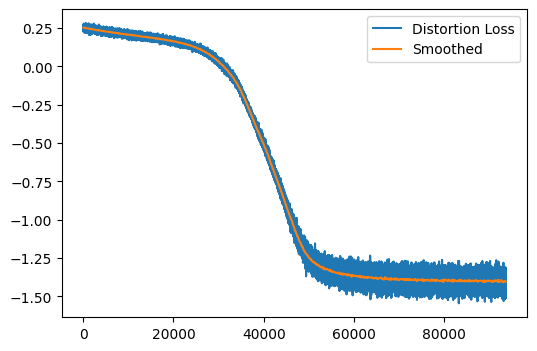

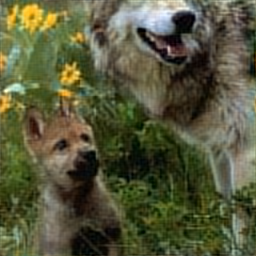

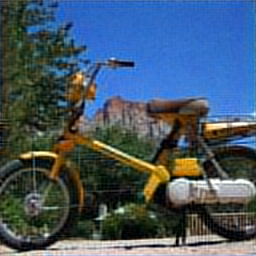

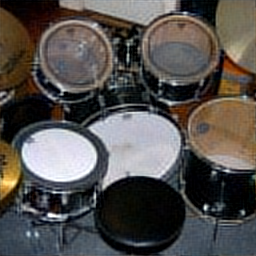

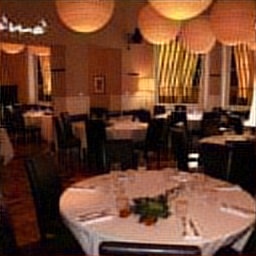

In [ ]:
warnings.filterwarnings("ignore", message="Truncated File Read", category=UserWarning, module="PIL.TiffImagePlugin")
dist_losses, rate_losses = [], []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
codec.train()
optimizer.zero_grad()
mb = master_bar(range(config.epochs))
mb.names = ['Distortion Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        drop_last=True,
        shuffle=True,
        collate_fn=collate_fn
    )
   
    for i, batch in enumerate(progress_bar(dataloader, parent=mb)):
    
        x = batch.to(device)
        x = x.to(torch.float)
        x = x/255
        x = x-0.5

        _, mse_loss, _, _ = codec(x)

        dist_loss = mse_loss
        dist_losses.append(np.log10(dist_loss.item()))
        loss = dist_loss
        loss.backward()
        if (i + 1) % config.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(dist_losses) % config.plot_update == 0:
            plot_n = len(dist_losses) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(dist_losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(dist_losses))
            dist_y = dist_losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                codec.eval()
                y_valid, _, _, _= codec(valid_batch)
                codec.train()
            
            for img_idx, img in enumerate(y_valid):
                buffer = io.BytesIO()
                ToPILImage()(img + 0.5).save(buffer, format="PNG")
                # ToPILImage()(img + 0.5).save(f"video/{img_idx}_{i_epoch}_{i}.png")
                buffer.seek(0)
                if len(img_displays) <= img_idx:
                    img_displays.append(display(Image(buffer.read()), display_id=True))
                else:
                    update_display(Image(buffer.read()), display_id=img_displays[img_idx].display_id)
        i_step+=1
        
    torch.save({
        'model_state_dict': codec.state_dict(),
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'dist_losses': dist_losses,
        'config': config
    }, f"log_{device}.pth")

In [9]:
from IPython.display import display, update_display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

In [11]:
torch.save({
    'model_state_dict': codec.state_dict(),
}, "../../hf/walloc/residual_J4.pth")

In [12]:
import json
with open('../../hf/walloc/residual_J4.json', 'w') as f:
    json.dump(config.__dict__, f, indent=4)

In [14]:
codec.eval()
with torch.no_grad():
    X = codec.wavelet_analysis(valid_batch, codec.J)
    residual = X
    Z_all = []
    for i in range(codec.num_stages):
        Z = codec.to_uniform(codec.encoders[i](residual))
        Z_all.append(Z)
        decoded = codec.to_normal(Z)
        residual = residual - codec.decoders[i](decoded)
    Z_combined = torch.cat(Z_all, dim=1)

In [23]:
with torch.no_grad():
    cumulative_reconstruction = torch.zeros_like(X)
    start_idx = 0
    for i in range(codec.num_stages):
        latent_dim = codec.latent_dim
        Z_stage = Z_combined[:, start_idx:start_idx + latent_dim, :, :]
        start_idx += latent_dim
        decoded = codec.to_normal(Z_stage)
        X_hat_stage = codec.decoders[i](decoded)
        cumulative_reconstruction = cumulative_reconstruction + X_hat_stage
    final_reconstruction = codec.wavelet_synthesis(cumulative_reconstruction, codec.J)

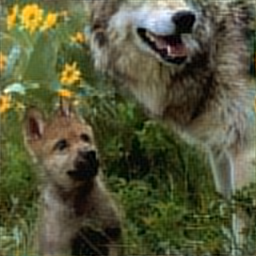

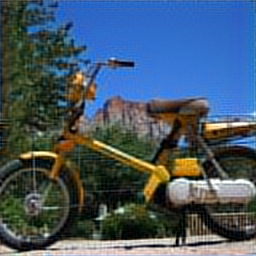

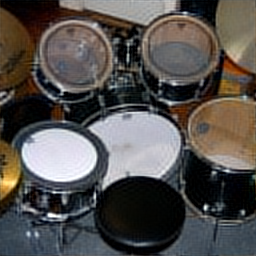

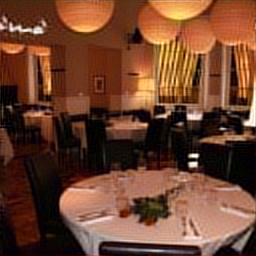

In [29]:
for img_idx, img in enumerate(final_reconstruction):
    display(ToPILImage()(codec.clamp(img) + 0.5))

In [30]:
import zlib
bytes = Z_combined.round().to(torch.int8).detach().cpu().numpy().tobytes()
print(valid_batch.numel()/len(bytes))
print(valid_batch.numel()/len(zlib.compress(bytes,level=9)))

16.0
21.639755654614497


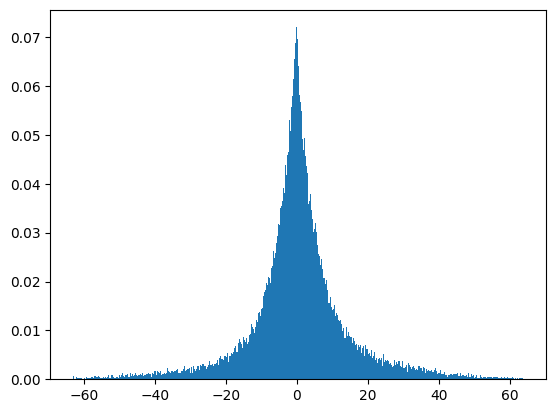

In [31]:
plt.hist(Z_combined.to("cpu").flatten().numpy(), density=True,range=(-63,64),bins=500);